In [1]:
from copy import deepcopy
import SimAnn as SA
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from generate_data import generate_data
import numpy as np
import sys
import time
import seaborn as sns
sys.path.append(
    "/Users/lucasfragara/Desktop/Bocconi/CS 2/Individual assignment")
import time 
from matplotlib import cm
import pandas as pd




In [2]:
class Optimizer:

    def __init__(self, n, seed=None, create_path = False):

        if seed:
            np.random.seed(seed)

        self.data = generate_data(n, "3233248")
        self.n = n
        self.config = self.init_config()  #{x: , y:}
        self.path = []
        self.create_path =  create_path

    def init_config(self):

        # TODO: Check this covers all possible combinations (i.e even borders)
        return {"x": np.random.randint(0, self.n-1), "y": np.random.randint(0, self.n-1)}

    def cost(self):

        x_t, y_t = self.config["x"], self.config["y"]

        return self.data[x_t, y_t]

    def propose_move(self):
        
        n = self.n
        move_x = 0
        move_y = 0
        while move_x == 0 and move_y == 0:
            move_x = np.random.choice([-1, 0, 1])
            move_y = np.random.choice([-1, 0, 1])
        
       
        x_prop = (self.config["x"] + move_x)%n
        
        y_prop = (self.config["y"] + move_y)%n 

        return (x_prop, y_prop)

    def accept_move(self, move, beta):

        x_prop, y_prop = move

        self.config["x"] = x_prop
        self.config["y"] = y_prop
        
        if self.create_path:
            self.path.append([x_prop, y_prop, self.data[x_prop, y_prop], beta])

    def compute_delta_cost(self, move):

        x_prop, y_prop = move
        x_t, y_t = self.config["x"], self.config["y"]

        return self.data[x_prop, y_prop] - self.data[x_t, y_t]

    def display(self, fig):

        plt.clf()
        ax = plt.axes(projection='3d')

        x = np.arange(self.n)
        y = np.arange(self.n)

        X, Y = np.meshgrid(x, y)

        z = self.data

        #ax.scatter(self.config["x"], self.config["y"],
         #          self.data[self.config["x"], self.config["y"]], color="red", s=10)
         
        if self.create_path: 
            self.path = list(zip(*self.path))
            
            cmap = cm.viridis
            norm = plt.Normalize(min(self.path[3]), max(self.path[3]))
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])

            
            ax.scatter(self.path[0], self.path[1], self.path[2], s = 5, c = self.path[3], cmap=cmap)
        
        ax.plot_surface(Y, X, z, alpha=0.5)
        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        ax.set_zlabel("z-axis")

    def copy(self):
        return self.config


In [3]:
def early_stop_hook(best_c):
    if best_c < -100:
        return False 

In [36]:
start_time  = time.time()

optimizer = Optimizer(70, seed=123, create_path = False)

true_min = np.min(optimizer.data)


beta_list = SA.linearbeta(beta0=0.01, beta1=1, steps=1000)
best_c, hist = SA.simann(optimizer, mcmc_steps=100,
                             beta_list=beta_list, seed=10, mc_hook= early_stop_hook)

print("Time taken: {}".format(np.round(time.time()-start_time, 2)))

fig0 = plt.figure()
#optimizer.display(fig0)


Time taken: 0.03


<Figure size 640x480 with 0 Axes>

### Varying Problem Size

In [44]:
#problem_sizes = [100, 200, 500, 1000, 5000]

problem_sizes = [100, 200, 500, 1000, 5000]

simulations = 10
anneal_steps = 100
mcmc_steps = 100

data = np.zeros(shape = (simulations*len(problem_sizes), 4)) #columns are: problem size, last step (i.e. step at which it converged), best cost

beta_list = SA.linearbeta(beta0=0.01, beta1=1, steps=anneal_steps)


#LINEAR BETA
i = 0
for problem_size in problem_sizes: 
    for sim in range(simulations):
        
        optimizer = Optimizer(problem_size, create_path = False)
        true_min = np.min(optimizer.data)
        
        epoch, hist = SA.simann(optimizer, mcmc_steps=100,
                             beta_list=beta_list, seed=10, mc_hook= early_stop_hook)
        
        data[i][0] = problem_size
        data[i][1] = epoch
        data[i][2] = hist[epoch-1][4] #get the last best cost
        data[i][3] = np.abs(data[i][2]-true_min)/true_min
        i += 1
        

In [46]:
data_df = pd.DataFrame(data, columns=["problem_size", "last_step", "best_cost", "convergence_error"])
data_df.to_csv("data_varying_sizes")

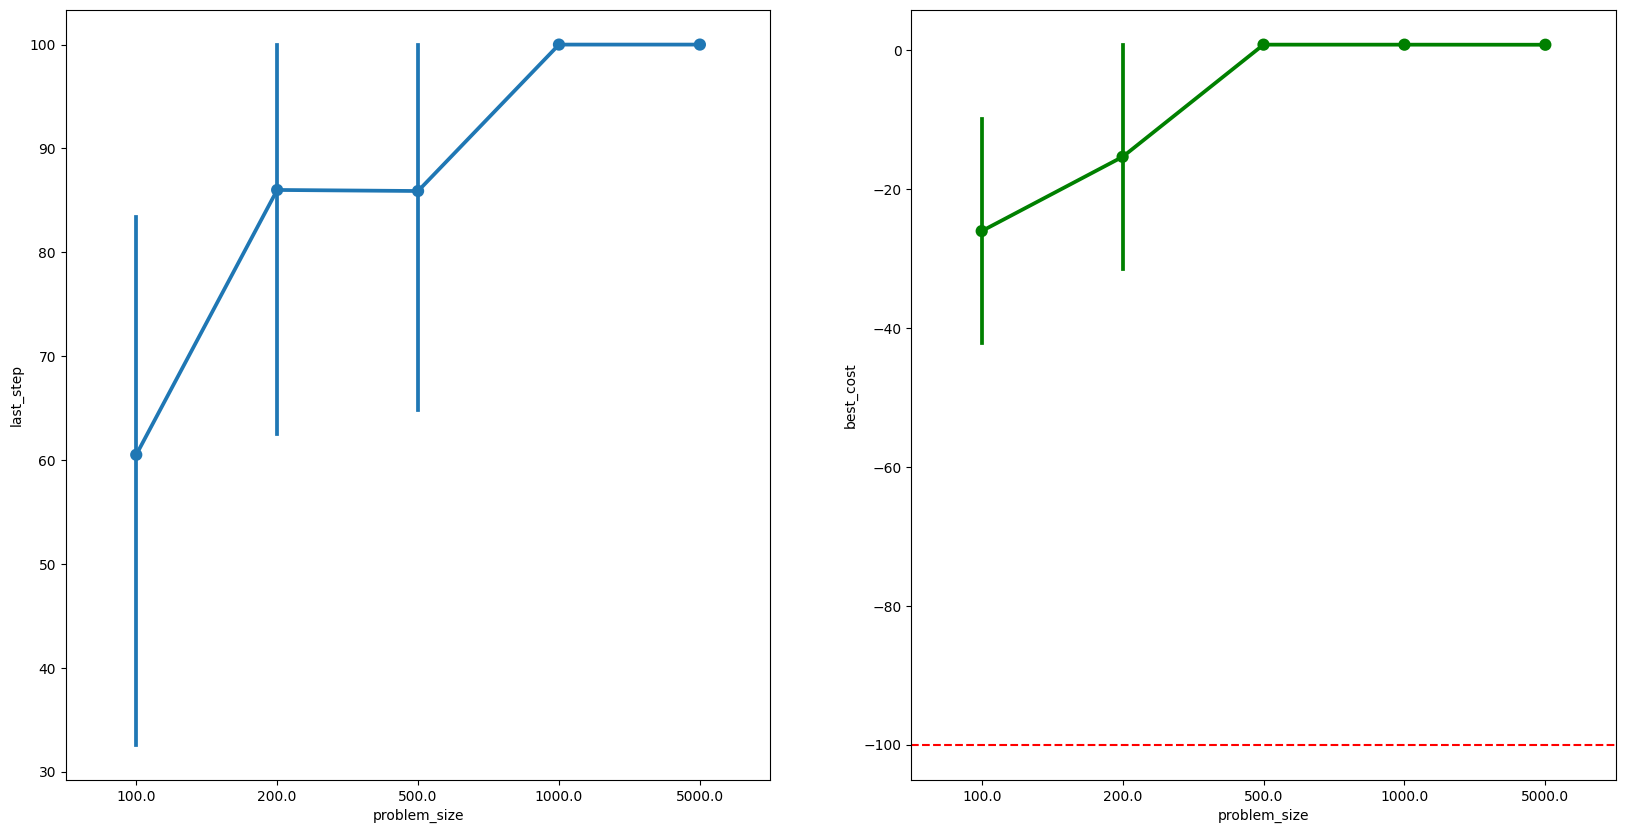

In [56]:
fig, (ax0, ax1) = plt.subplots(1,2)
fig.set_size_inches(20,10)

sns.pointplot(data = data_df, x = "problem_size", y = "last_step", ax = ax0, label = "last step")

sns.pointplot(data = data_df, x = "problem_size", y = "best_cost", ax = ax1, color = "green", label = "convergence error")
ax1.axhline(y=-100, color='red', linestyle='--', label='Horizontal Line at -100')

plt.show()

<AxesSubplot: xlabel='epoch', ylabel='Current_cost'>

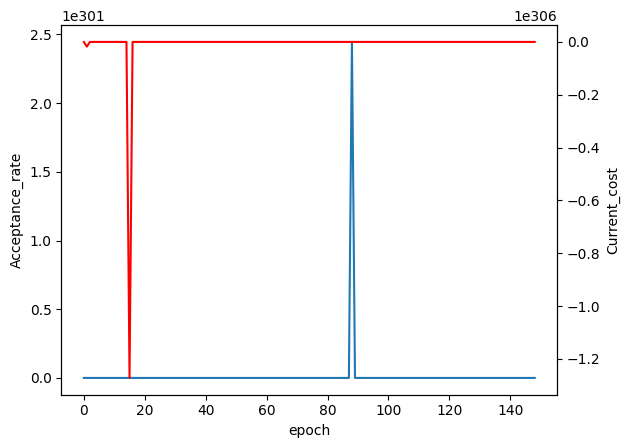

In [ ]:
sns.lineplot(data = hist[:-1], x = "epoch", y = "Acceptance_rate")
ax2 = plt.twinx()
sns.lineplot(data = hist[:-1], x = "epoch", y = "Current_cost", ax=ax2, color = "red")


## Analyzing move proposal

In [ ]:
#creating a 4 x 4 grid
from collections import Counter
import pandas as pd
n = 10
grid = np.arange(0, n**2).reshape(n, n)

#numbers picked
n_picks = 100000

choices = np.empty(n_picks, dtype=int)
choices2 = np.empty(n_picks, dtype=int)


for x in range(n_picks):
    

    proposed_x = np.random.choice([(proposed_x-1)%n, proposed_x, (proposed_x+1)%n])
    proposed_y = np.random.choice([(proposed_y-1)%n, proposed_y, (proposed_y+1)%n])

    #without modulo operation
""""
    if proposed_x2 == 0:
        proposed_x2 += 1
    elif proposed_x2 == n-1:
        proposed_x2 -= 1
    else: 
        proposed_x2 = np.random.choice([(proposed_x2-1), (proposed_x2+1)])

    if proposed_y2 == 0:
        proposed_y2 += 1
    elif proposed_y2 == n-1:
        proposed_y2 -= 1    
    else:
        proposed_y2 = np.random.choice([(proposed_y2-1),(proposed_y2+1)])
    choices2[x] = grid[proposed_x2, proposed_y2]
"""
choices[x] = grid[proposed_x, proposed_y]



all_values = np.arange(n**2)
counter = Counter(dict.fromkeys(all_values, 0))

#counter2 = Counter(dict.fromkeys(all_values, 0))

# Update counter with the actual counts
counter.update(choices)
counter_df = pd.DataFrame(list(counter.items()), columns=['Number', 'Count'])

#counter2.update(choices2)
#counter_df2 = pd.DataFrame(list(counter2.items()), columns=['Number', 'Count'])

counter_df["Count"] /= counter_df['Count'].sum()
#counter_df2["Count"] /= counter_df2['Count'].sum()

# Plot the barplot
fig, (ax0, ax1) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

sns.barplot(x='Number', y='Count', data=counter_df, ax = ax0).set(title = "With modulo operation")

#sns.barplot(x='Number', y='Count', data=counter_df2, ax = ax1).set(title = "Without modulo operation")




NameError: name 'proposed_x' is not defined

<AxesSubplot: >

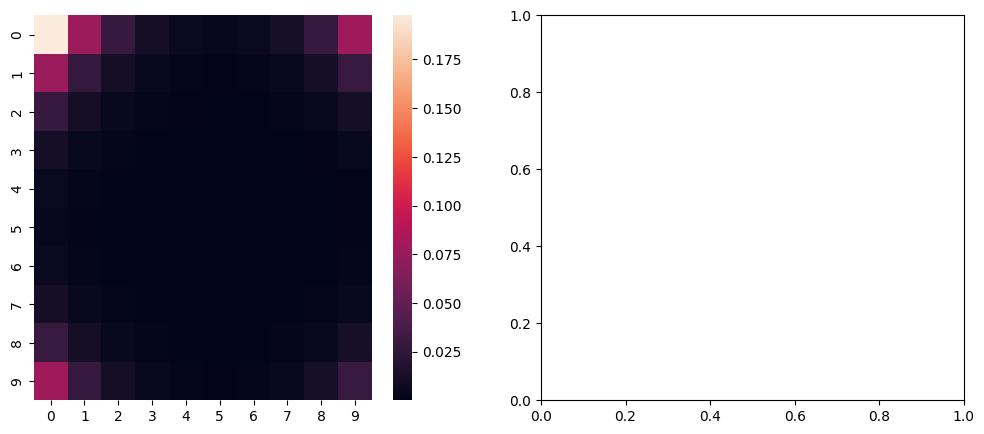

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

sns.heatmap(data = counter_df.Count.to_numpy().reshape(n,n), ax = ax0)

#sns.heatmap(data = counter_df2.Count.to_numpy().reshape(n,n), ax = ax1)